# Example preprocessing notebook

In this notebook we are going to walk through a single patient example. There are probably some patient-specific stuff in here that might change with other patients. Should be able to demonstrate the usage of different functions from the toolbox.

1. Load raw data (.edf in this notebook) using mne

2. Add in electrode information

3. Notch filter line noise and cleaning out bad channels 

4. Re-reference the data 

5. Annotate data (i.e. artifact and IEDs) 


Must read guides: 

https://www.sciencedirect.com/science/article/pii/S1053811922005559


In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import re

In [3]:
import sys
sys.path.append('/hpc/users/qasims01/resources/LFPAnalysis')

In [4]:
from LFPAnalysis import lfp_preprocess_utils, sync_utils, nlx_utils

## Load raw data (.nlx in this notebook) using mne

It's a good idea to setup a sensible directory structure like below. Note that all my data lives on '/sc/arion' which is Minerva. 


mne: https://mne.tools/stable/index.html

In [5]:
base_dir = '/sc/arion' # this is the root directory for most un-archived data and results 

save_dir = f'{base_dir}/work/qasims01/MemoryBanditData/EMU/Subjects/MS022'  # save intermediate results in the 'work' directory
    
# I have saved most of my raw data in the 'projects directory'
behav_dir = f'{base_dir}/projects/guLab/Salman/EMU/MS022/behav/Day1'
neural_dir = f'{base_dir}/projects/guLab/Salman/EMU/MS022/neural/Day1'
anat_dir = f'{base_dir}/projects/guLab/Salman/EMU/MS022/anat'


In [6]:
load_path = neural_dir

In [7]:
eeg_names = ['fp1', 'f7', 't3', 't5', 'o1', 'f3', 'c3', 'p3', 'fp2', 'f8', 't4', 't6', 'o2', 'f4', 'c4', 'p4', 'fz', 'cz', 'pz']


In [8]:
seeg_names = None
resp_names = None
ekg_names = None

In [9]:
# per Shawn, MSSM data seems to sometime have a "_0000.ncs" to "_9999.ncs" appended to the end of real data
pattern = re.compile(r"_\d{4}\.ncs")  # regex pattern to match "_0000.ncs" to "_9999.ncs"
ncs_files = [x for x in glob(f'{load_path}/*.ncs') if re.search(pattern, x)]
# just in case this changes in the future: 
if len(ncs_files) == 0: 
    ncs_files = glob(f'{load_path}/*.ncs')
    if not seeg_names:
        seeg_names = [x.split('/')[-1].replace('.ncs','') for x in glob(f'{load_path}/[R,L]*.ncs')]
else:
    if not seeg_names:
        seeg_names = [x.split('/')[-1].replace('.ncs','').split('_')[0] for x in glob(f'{load_path}/[R,L]*.ncs') if re.search(pattern, x)]

In [10]:
seeg_names = [x.lower() for x in seeg_names]
sEEG_mapping_dict = {f'{x}':'seeg' for x in seeg_names}

In [11]:
signals = [] 
srs = [] 
ch_name = [] 
ch_type = []

In [12]:
for chan_path in ncs_files:
    chan_name = chan_path.split('/')[-1].replace('.ncs','')
    # strip the file type off the end if needed 
    if '_' in chan_name:
        chan_name = chan_name.split('_')[0]
    try:
        fdata = nlx_utils.load_ncs(chan_path)
    except IndexError: 
        print(f'No data in channel {chan_name}')
        continue
    if eeg_names:
        if chan_name.lower() in eeg_names:
            ch_type.append('eeg')
    if resp_names:
        if chan_name.lower() in resp_names:
            ch_type.append('bio')
    if ekg_names:
        if chan_name.lower() in ekg_names: 
            ch_type.append('ecg') 
    if seeg_names: 
        if chan_name.lower() in seeg_names:
            ch_type.append('seeg')  
        elif chan_name.lower()[0] == 'u':
            # microwire data
            ch_type.append('seeg')  
    signals.append(fdata['data'])
    srs.append(fdata['sampling_rate'])
    ch_name.append(chan_name)
    if len(ch_type) < len(ch_name):
        ch_type.append('misc')
        print(f'Unidentified data type in {chan_name}')

/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/nlx_utils.py:82: UserWarning: Unable to parse original file path from Neuralynx header: -FileType NCS
  warnings.warn('Unable to parse original file path from Neuralynx header: ' + hdr_lines[1])
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/nlx_utils.py:134: UserWarning: Unable to parse time string from Neuralynx header: -FileVersion 3.4
  warnings.warn('Unable to parse time string from Neuralynx header: ' + time_string)
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/nlx_utils.py:134: UserWarning: Unable to parse time string from Neuralynx header: -FileUUID 2623c1e9-e532-42cc-9e7a-fe23bec5609a
  warnings.warn('Unable to parse time string from Neuralynx header: ' + time_string)
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/nlx_utils.py:96: UserWarning: Unable to parse parameter line from Neuralynx header: -ProbeName
  warnings.warn('Unable to parse parameter line from Neuralynx header: ' + line)
/hpc/users/qasi

Unidentified data type in Analog4


/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/nlx_utils.py:134: UserWarning: Unable to parse time string from Neuralynx header: -FileUUID 959cb163-d218-4c33-9620-dc15f647560f
  warnings.warn('Unable to parse time string from Neuralynx header: ' + time_string)
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/nlx_utils.py:96: UserWarning: Unable to parse parameter line from Neuralynx header: -TimeClosed 2023/02/05 10:56:17
  warnings.warn('Unable to parse parameter line from Neuralynx header: ' + line)
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/nlx_utils.py:96: UserWarning: Unable to parse parameter line from Neuralynx header: -ReferenceChannel "Source 03 Subject Ground"
  warnings.warn('Unable to parse parameter line from Neuralynx header: ' + line)
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/nlx_utils.py:134: UserWarning: Unable to parse time string from Neuralynx header: -FileUUID 71544c0d-e6d8-4b5a-a8f4-c3b722541447
  warnings.warn('Unable to parse t

Unidentified data type in ABS1


/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/nlx_utils.py:134: UserWarning: Unable to parse time string from Neuralynx header: -FileUUID 393740ff-230e-433d-b780-178e3ef14ec8
  warnings.warn('Unable to parse time string from Neuralynx header: ' + time_string)
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/nlx_utils.py:134: UserWarning: Unable to parse time string from Neuralynx header: -FileUUID fcb8da22-488c-495a-a823-592319966658
  warnings.warn('Unable to parse time string from Neuralynx header: ' + time_string)
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/nlx_utils.py:134: UserWarning: Unable to parse time string from Neuralynx header: -FileUUID 2ffa7a06-84ed-4d2d-8dc0-f76c0a05f3a0
  warnings.warn('Unable to parse time string from Neuralynx header: ' + time_string)
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/nlx_utils.py:134: UserWarning: Unable to parse time string from Neuralynx header: -FileUUID c165f11b-2178-417d-8651-dd0fab5b2f0b
  warnings.wa

Unidentified data type in EKG1


/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/nlx_utils.py:134: UserWarning: Unable to parse time string from Neuralynx header: -FileUUID afbbc14b-91c9-4359-8c2c-b59b32ca9514
  warnings.warn('Unable to parse time string from Neuralynx header: ' + time_string)
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/nlx_utils.py:134: UserWarning: Unable to parse time string from Neuralynx header: -FileUUID 9de02852-1dc2-4de2-8b81-19db8dc3fcc8
  warnings.warn('Unable to parse time string from Neuralynx header: ' + time_string)


Unidentified data type in Mic


/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/nlx_utils.py:134: UserWarning: Unable to parse time string from Neuralynx header: -FileUUID 979d433b-d012-4a25-82dc-c054811c867f
  warnings.warn('Unable to parse time string from Neuralynx header: ' + time_string)
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/nlx_utils.py:134: UserWarning: Unable to parse time string from Neuralynx header: -FileUUID 92067a0d-8c2e-4ed7-b9c2-7025efb7a0c6
  warnings.warn('Unable to parse time string from Neuralynx header: ' + time_string)
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/nlx_utils.py:134: UserWarning: Unable to parse time string from Neuralynx header: -FileUUID 48fd226d-5a37-451d-9100-612e5cf5de41
  warnings.warn('Unable to parse time string from Neuralynx header: ' + time_string)


Unidentified data type in Photodiode


/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/nlx_utils.py:134: UserWarning: Unable to parse time string from Neuralynx header: -FileUUID 16ef7377-5f8d-4652-ab25-1f527a13116c
  warnings.warn('Unable to parse time string from Neuralynx header: ' + time_string)
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/nlx_utils.py:134: UserWarning: Unable to parse time string from Neuralynx header: -FileUUID c2584992-90bb-4624-85cf-53ad7ecc99ca
  warnings.warn('Unable to parse time string from Neuralynx header: ' + time_string)
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/nlx_utils.py:134: UserWarning: Unable to parse time string from Neuralynx header: -FileUUID 512a44f5-6bfe-45d9-8c8a-55ec4d4a7b6b
  warnings.warn('Unable to parse time string from Neuralynx header: ' + time_string)
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/nlx_utils.py:134: UserWarning: Unable to parse time string from Neuralynx header: -FileUUID 80bf0833-33cf-4605-a8c5-6595a9c59c22
  warnings.wa

Unidentified data type in Audio


/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/nlx_utils.py:134: UserWarning: Unable to parse time string from Neuralynx header: -FileUUID 024987bd-15fc-417f-95fb-558c1edec501
  warnings.warn('Unable to parse time string from Neuralynx header: ' + time_string)
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/nlx_utils.py:96: UserWarning: Unable to parse parameter line from Neuralynx header: -ReferenceChannel "Source 04 Subject Ground"
  warnings.warn('Unable to parse parameter line from Neuralynx header: ' + line)


Unidentified data type in CHEST2


/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/nlx_utils.py:134: UserWarning: Unable to parse time string from Neuralynx header: -FileUUID 581c6652-e14a-4977-b241-17390fb824a0
  warnings.warn('Unable to parse time string from Neuralynx header: ' + time_string)
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/nlx_utils.py:96: UserWarning: Unable to parse parameter line from Neuralynx header: -ReferenceChannel "AD Channel 0195"
  warnings.warn('Unable to parse parameter line from Neuralynx header: ' + line)
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/nlx_utils.py:134: UserWarning: Unable to parse time string from Neuralynx header: -FileUUID acfb5007-1bd7-41f2-871b-41e15bab49a0
  warnings.warn('Unable to parse time string from Neuralynx header: ' + time_string)
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/nlx_utils.py:134: UserWarning: Unable to parse time string from Neuralynx header: -FileUUID 692e3221-f54f-43c6-ab02-db1699727727
  warnings.warn('Unable to

Unidentified data type in BLANK2


/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/nlx_utils.py:134: UserWarning: Unable to parse time string from Neuralynx header: -FileUUID 715dcb1d-926f-413c-ade9-af4bf4dbfe79
  warnings.warn('Unable to parse time string from Neuralynx header: ' + time_string)
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/nlx_utils.py:134: UserWarning: Unable to parse time string from Neuralynx header: -FileUUID 2f1c0985-8418-4f31-bb00-064cbbc7ee3c
  warnings.warn('Unable to parse time string from Neuralynx header: ' + time_string)
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/nlx_utils.py:134: UserWarning: Unable to parse time string from Neuralynx header: -FileUUID ee4aba97-ede6-469d-964c-f539fb5c0fc7
  warnings.warn('Unable to parse time string from Neuralynx header: ' + time_string)
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/nlx_utils.py:134: UserWarning: Unable to parse time string from Neuralynx header: -FileUUID 2662efdc-4a60-4ccd-9985-fef5774ba588
  warnings.wa

Unidentified data type in EKG2


/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/nlx_utils.py:134: UserWarning: Unable to parse time string from Neuralynx header: -FileUUID 1080f445-82f7-4164-89af-9ef14fd972f8
  warnings.warn('Unable to parse time string from Neuralynx header: ' + time_string)
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/nlx_utils.py:134: UserWarning: Unable to parse time string from Neuralynx header: -FileUUID 83c95854-b0a4-4fb7-add2-d46d14c7c5d2
  warnings.warn('Unable to parse time string from Neuralynx header: ' + time_string)
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/nlx_utils.py:134: UserWarning: Unable to parse time string from Neuralynx header: -FileUUID bf8cf8a9-b734-462a-a836-af2964f2be22
  warnings.warn('Unable to parse time string from Neuralynx header: ' + time_string)
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/nlx_utils.py:134: UserWarning: Unable to parse time string from Neuralynx header: -FileUUID 8db8a6db-3665-4146-978a-0a84257390b9
  warnings.wa

Unidentified data type in CHEST1


/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/nlx_utils.py:134: UserWarning: Unable to parse time string from Neuralynx header: -FileUUID ce87ad17-bd13-408d-b40a-a4d436a5710a
  warnings.warn('Unable to parse time string from Neuralynx header: ' + time_string)
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/nlx_utils.py:134: UserWarning: Unable to parse time string from Neuralynx header: -FileUUID 02170735-2453-460f-8a34-b5d1d18ac56b
  warnings.warn('Unable to parse time string from Neuralynx header: ' + time_string)
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/nlx_utils.py:134: UserWarning: Unable to parse time string from Neuralynx header: -FileUUID 7ae1c7fe-8928-4ef8-9be8-a7c3812e6d5e
  warnings.warn('Unable to parse time string from Neuralynx header: ' + time_string)
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/nlx_utils.py:134: UserWarning: Unable to parse time string from Neuralynx header: -FileUUID 3ce34952-f769-45a0-a3f1-d76654d67e8f
  warnings.wa

/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/nlx_utils.py:134: UserWarning: Unable to parse time string from Neuralynx header: -FileUUID d456e6c6-3ab3-40a6-a3b6-8afc8bf82a99
  warnings.warn('Unable to parse time string from Neuralynx header: ' + time_string)
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/nlx_utils.py:134: UserWarning: Unable to parse time string from Neuralynx header: -FileUUID 3cdcd468-9c7b-40c0-b5f1-c65e5e4f48ae
  warnings.warn('Unable to parse time string from Neuralynx header: ' + time_string)


Unidentified data type in ABS2


/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/nlx_utils.py:134: UserWarning: Unable to parse time string from Neuralynx header: -FileUUID df738148-7a8a-4a3d-8f2e-68955c57613a
  warnings.warn('Unable to parse time string from Neuralynx header: ' + time_string)


Unidentified data type in BLANK1


/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/nlx_utils.py:134: UserWarning: Unable to parse time string from Neuralynx header: -FileUUID 42430b23-d3ed-4cea-9175-05bcd2dba695
  warnings.warn('Unable to parse time string from Neuralynx header: ' + time_string)
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/nlx_utils.py:134: UserWarning: Unable to parse time string from Neuralynx header: -FileUUID f86046c4-bb91-4230-8761-a36a015a9e6f
  warnings.warn('Unable to parse time string from Neuralynx header: ' + time_string)
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/nlx_utils.py:134: UserWarning: Unable to parse time string from Neuralynx header: -FileUUID e3528fe5-b798-43a4-a353-573654b37141
  warnings.warn('Unable to parse time string from Neuralynx header: ' + time_string)
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/nlx_utils.py:134: UserWarning: Unable to parse time string from Neuralynx header: -FileUUID 4e4b595f-13ca-4196-8718-d4a78e101282
  warnings.wa

In [14]:
target_sr = np.min(srs)
mne_data_resampled = []

In [15]:
for sr in np.unique(srs):
    ch_ix = np.where(srs==sr)[0].astype(int)
    info = mne.create_info([x for ix, x in enumerate(ch_name) if ix in ch_ix], sr, [x for ix, x in enumerate(ch_type) if ix in ch_ix])
    mne_data_temp = mne.io.RawArray([x for ix, x in enumerate(signals) if ix in ch_ix], info)
    if sr != target_sr:
        # resample down to one sample rate 
        mne_data_temp.resample(sfreq=target_sr, npad='auto', n_jobs=-1)
        mne_data_resampled.append(mne_data_temp)
    else: 
        mne_data = mne_data_temp
        

Creating RawArray with float64 data, n_channels=95, n_times=4866048
    Range : 0 ... 4866047 =      0.000 ...  2433.023 secs
Ready.
Creating RawArray with float64 data, n_channels=22, n_times=77853696
    Range : 0 ... 77853695 =      0.000 ...  2432.928 secs
Ready.


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:  1.7min finished


In [29]:
#Because of the resampling, the end timings might not match perfectly:https://github.com/mne-tools/mne-python/issues/8257

if mne_data_resampled[0].tmax > mne_data.tmax:
    mne_data_resampled[0].crop(tmin=0, tmax=mne_data.tmax)
elif mne_data_resampled[0].tmax < mne_data.tmax:
    mne_data.crop(tmin=0, tmax=mne_data_resampled[0].tmax)
    

In [30]:
mne_data.add_channels(mne_data_resampled)

<RawArray | 117 x 4865856 (2432.9 s), ~4.24 GB, data loaded>

Try loading in the data into memory

In [33]:
mne_data.ch_names
mne_data.info['line_freq'] = 60
# Notch out 60 Hz noise and harmonics 
mne_data.notch_filter(freqs=(60, 120, 180, 240))

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13201 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed:   25.0s finished


<RawArray | 117 x 4865856 (2432.9 s), ~4.24 GB, data loaded>

In [36]:
drop_chans = list(set([x.lower() for x in mne_data.ch_names])^set(seeg_names))

In [40]:
new_name_dict = {x:x.replace(" ", "").lower() for x in mne_data.ch_names}
mne_data.rename_channels(new_name_dict)

<RawArray | 117 x 4865856 (2432.9 s), ~4.24 GB, data loaded>

In [41]:
mne_data.drop_channels(drop_chans)

<RawArray | 70 x 4865856 (2432.9 s), ~2.54 GB, data loaded>

In [43]:
bads = lfp_preprocess_utils.detect_bad_elecs(mne_data, sEEG_mapping_dict)
mne_data.info['bads'] = bads

In [44]:
mne_data.info['bads'] = bads

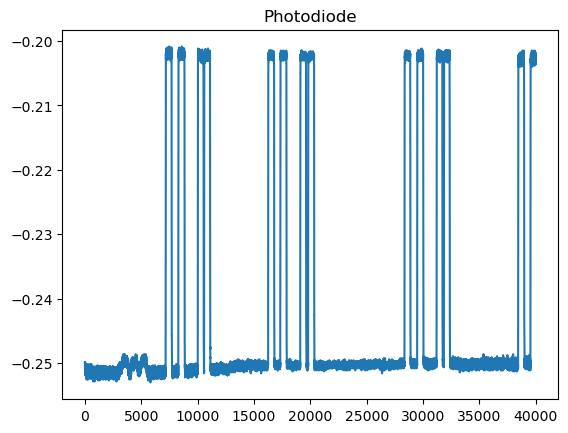

In [8]:
# Sanity check the photodiode
trig_ix = MS007_data.ch_names.index('DC1')
plt.plot(MS007_data._data[trig_ix, 10000:50000])
plt.title("Photodiode")
plt.show()

## Add in electrode information

In [67]:
# Load the electrode localization data and add it in

csv_files = glob(f'{anat_dir}/*labels.csv')
elec_locs = pd.read_csv(csv_files[0])

# Sometimes there's extra columns with no entries: 
elec_locs = elec_locs[elec_locs.columns.drop(list(elec_locs.filter(regex='Unnamed')))]

# # identify the bundles for re-referencing:
# loc_data['bundle'] = np.nan
# loc_data['bundle'] = loc_data.apply(lambda x: ''.join(i for i in x.label if not i.isdigit()), axis=1)



In [68]:
elec_locs

label BN246label          x          y          z      mni_x      mni_y  \
0   LaCaS1    A32sg_L  -7.998392  33.753014  11.599995  -7.303106  29.507935   
1   LaCaS2    Unknown -11.997591  33.753014  15.199995 -11.263673  31.336920   
2   LaCaS3    Unknown -15.596870  33.753014  19.199995 -14.826880  33.353221   
3   LaCaS4    Unknown -19.196148  34.551902  21.599995 -18.475267  35.217119   
4   LaCaS5    Unknown -22.395507  34.551902  24.799995 -21.683689  36.761797   
..     ...        ...        ...        ...        ...        ...        ...   
67  LplfO4    Unknown -49.590058  -4.194170  19.999995 -47.937431  -2.052692   
68  LplfO5     A4hf_L -54.389097  -3.794726  21.599995 -52.836611  -1.118054   
69  LplfO6     A4hf_L -59.987975  -2.995838  23.599995 -58.569705   0.138888   
70  uLaCaS    A32sg_L  -5.598873  34.152458   9.999995  -5.000333  29.004945   
71  uLmOlF    A32sg_L  -5.198953  38.546343   7.599996  -4.863348  31.539595   

        mni_z     gm                                 NMM      Anat  \
0   -4.544081   Gray  Left ACgG anterior cingulate gyrus  Area s24   
1   -0.649451  White          Left Cerebral White Matter   Unknown   
2    3.587480  White          Left Cerebral White Matter   Unknown   
3    5.812331  White          Left Cerebral White Matter   Unknown   
4    9.288654  White          Left Cerebral White Matter   Unknown   
..        ...    ...                                 ...       ...   
67  25.197714   Gray          Left Cerebral White Matter   Unknown   
68  26.762258   Gray          Left Cerebral White Matter   Unknown   
69  28.441652   Gray           Left PrG precentral gyrus   Unknown   
70  -6.416785   Gray  Left ACgG anterior cingulate gyrus  Area s24   
71 -11.019659   Gray  Left ACgG anterior cingulate gyrus  Area s32   

              AnatMacro    BN246                   YBA_1  \
0                 L ACC     L CG  Left cingulate gyrus D   
1               Unknown  Unknown                 Unknown   
2               Unknown  Unknown                 Unknown   
3               Unknown  Unknown                 Unknown   
4               Unknown  Unknown                 Unknown   
..                  ...      ...                     ...   
67   L Precentral Gyrus  Unknown                 Unknown   
68   L Precentral Gyrus    L PrG  Left posterior motor I   
69   L Precentral Gyrus    L PrG  Left posterior motor I   
70                L ACC     L CG  Left cingulate gyrus D   
71  L Mid Orbital Gyrus     L CG  Left cingulate gyrus D   

        Manual Examination  Notes  
0                      NaN    NaN  
1                      NaN    NaN  
2                      NaN    NaN  
3                      NaN    NaN  
4                      NaN    NaN  
..                     ...    ...  
67  Left posterior motor I    NaN  
68                     NaN    NaN  
69                     NaN    NaN  
70                     NaN    NaN  
71                     NaN    NaN  

[72 rows x 16 columns]

The electrode names read out of the edf file do not always match those 
in the pdf (used for localization). This could be error on the side of the tech who input the labels, 
or on the side of MNE reading the labels in. Usually there's a mixup between lowercase 'l' and capital 'I'.

Sometimes, there's electrodes on the pdf that are NOT in the MNE data structure... let's identify those as well. 


In [9]:
new_mne_names, unmatched_names, unmatched_seeg = lfp_preprocess_utils.match_elec_names(MS007_data.ch_names, elec_locs.label)




Could not find a match for rhplt9.


So we retun a new list of channel names for the mne data structure as well as a list of channels in the localization csv which are not found in the mne structure. Make sure that unmatched_seeg does not factor into any referencing schemes later - it's not in the MNE data

In [10]:
# Rename the mne data according to the localization data
new_name_dict = {x:y for (x,y) in zip(MS007_data.ch_names, new_mne_names)}
MS007_data.rename_channels(new_name_dict)

<RawEDF | MS007_MemBandit.edf, 276 x 1867008 (1823.2 s), ~3.84 GB, data loaded>

In [38]:
unmatched_seeg

['rhplt9']

In [12]:
# Note, there is surface EEG data that we should separately indicate from the sEEG:
right_seeg_names = [i for i in MS007_data.ch_names if i.startswith('r')]
left_seeg_names = [i for i in MS007_data.ch_names if i.startswith('l')]
# This is optional. I might want to look at scalp EEG at some point (lol) so might as well tag them here. 
eeg_names = [
 'fp1',
 'f7',
 't3',
 't5',
 'o1',
 'f3',
 'c3',
 'p3',
 'fp2',
 'f8',
 't4',
 't6',
 'o2',
 'f4',
 'c4',
 'p4',
 'fz',
 'cz',
 'pz']
print(f'We have a total of {len(left_seeg_names) + len(right_seeg_names)} sEEG electrodes')
print(f'We have a total of {len(eeg_names)} EEG electrodes')
# MS007_data.set_channel_types()

We have a total of 196 sEEG electrodes
We have a total of 19 EEG electrodes


In [13]:
sEEG_mapping_dict = {f'{x}':'seeg' for x in left_seeg_names+right_seeg_names}
EEG_mapping_dict = {f'{x}':'eeg' for x in eeg_names}
trig_mapping_dict = {'dc1':'stim'}
# Drop random chans? 
drop_chans = list(set(MS007_data.ch_names)^set(eeg_names+left_seeg_names+right_seeg_names+['dc1']))
MS007_data.drop_channels(drop_chans)

<RawEDF | MS007_MemBandit.edf, 216 x 1867008 (1823.2 s), ~3.00 GB, data loaded>

In [14]:
# Set channel types:
MS007_data.set_channel_types(sEEG_mapping_dict)
MS007_data.set_channel_types(EEG_mapping_dict)
MS007_data.set_channel_types(trig_mapping_dict)

/tmp/ipykernel_182879/1830004009.py:4: RuntimeWarning: The unit for channel(s) dc1 has changed from V to NA.
  MS007_data.set_channel_types(trig_mapping_dict)


<RawEDF | MS007_MemBandit.edf, 216 x 1867008 (1823.2 s), ~3.00 GB, data loaded>

In [15]:
# make montage (convert mm to m)!! I'm not sure if we will ever use or need this step, but why not just do it

montage = mne.channels.make_dig_montage(ch_pos=dict(zip(elec_locs.label, 
                                                        elec_locs[['mni_x', 'mni_y', 'mni_z']].to_numpy(dtype=float)/1000)),
                                        coord_frame='mni_tal')

MS007_data.set_montage(montage, match_case=False, on_missing='warn')


/tmp/ipykernel_182879/3983129385.py:7: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  MS007_data.set_montage(montage, match_case=False, on_missing='warn')
/tmp/ipykernel_182879/3983129385.py:7: RuntimeWarning: DigMontage is only a subset of info. There are 19 channel positions not present in the DigMontage. The required channels are:

['fp1', 'f7', 't3', 't5', 'o1', 'f3', 'c3', 'p3', 'fp2', 'f8', 't4', 't6', 'o2', 'f4', 'c4', 'p4', 'fz', 'cz', 'pz'].

Consider using inst.set_channel_types if these are not EEG channels, or use the on_missing parameter if the channel positions are allowed to be unknown in your analyses.
  MS007_data.set_montage(montage, match_case=False, on_missing='warn')


<RawEDF | MS007_MemBandit.edf, 216 x 1867008 (1823.2 s), ~3.00 GB, data loaded>

## Notch filter line noise and cleaning out bad channels 


We want to remove the line noise (60 Hz and harmonics in US data, 50 Hz and harmonics in EU data). 

To do so, we use a band-stop filter that removes a narrow band of frequencies. 

Maybe eventually we don't want to use filters, especially if interested in ERPs: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6456018/

In [16]:
# Identify line noise
MS007_data.info['line_freq'] = 60

# Notch out 60 Hz noise and harmonics 
MS007_data.notch_filter(freqs=(60, 120, 180, 240))

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 215 out of 215 | elapsed:   13.5s finished


<RawEDF | MS007_MemBandit.edf, 216 x 1867008 (1823.2 s), ~3.00 GB, data loaded>

In [17]:
# Save out the photodiode channel separately
MS007_data.save(f'{save_dir}/photodiode.fif', picks='dc1', overwrite=True)

Overwriting existing file.
Writing /sc/arion/work/qasims01/MemoryBanditData/EMU/Subjects/MS007/photodiode.fif
Closing /sc/arion/work/qasims01/MemoryBanditData/EMU/Subjects/MS007/photodiode.fif
[done]


/tmp/ipykernel_182879/2725322655.py:2: RuntimeWarning: This filename (/sc/arion/work/qasims01/MemoryBanditData/EMU/Subjects/MS007/photodiode.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  MS007_data.save(f'{save_dir}/photodiode.fif', picks='dc1', overwrite=True)


Denote bad channels

In [18]:
# Clean up the MNE data 

bads = lfp_preprocess_utils.detect_bad_elecs(MS007_data, 
                                             sEEG_mapping_dict)

MS007_data.info['bads'] = bads

In [19]:
bads

['laglt10',
 'laglt8',
 'laglt9',
 'lcmfo7',
 'lhplt1',
 'lhplt2',
 'lmcms1',
 'lmcms2',
 'lmcms9',
 'lmolf4',
 'lmolf5',
 'racas8',
 'rpcip7']

In [20]:
# Let's pick out any bad channels missed by automatic screening, or restore channels that were erroneously deemed bad

When we plot the data using the interactive plotting, bad channels are grayed out. Can click them on the left to toggle this. We aren't annotating bad data time-windows yet! 

<IPython.core.display.Javascript object>


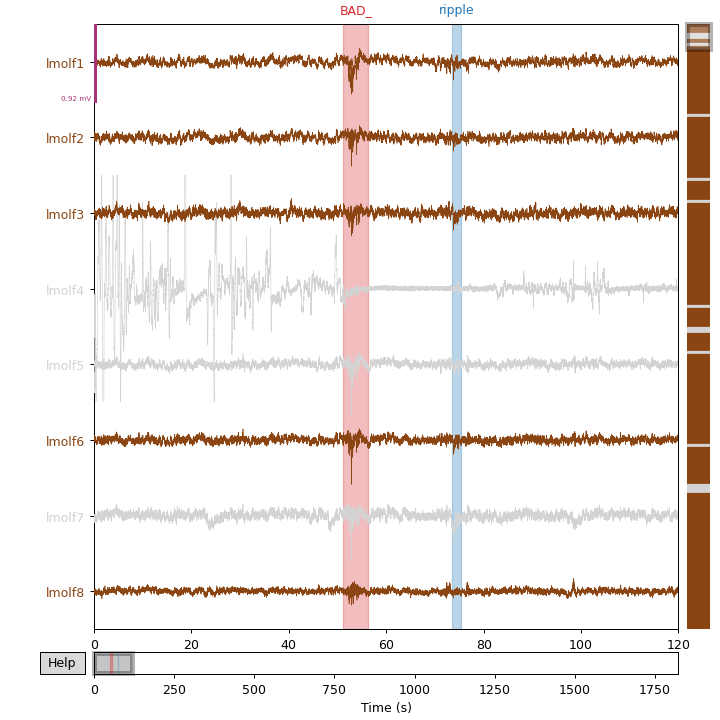

<IPython.core.display.Javascript object>


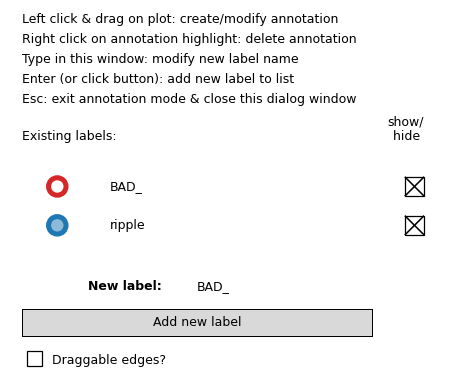

In [37]:
%matplotlib notebook
fig = MS007_data.plot(start=0, duration=120, n_channels=8, scalings=MS007_data._data.max()/20)
fig.fake_keypress('a')

Compare your revised list of 'bad' electrodes to thoe originally detected above.

In [22]:
MS007_data.info['bads']

['laglt10',
 'laglt8',
 'laglt9',
 'lcmfo7',
 'lmcms1',
 'lmcms2',
 'lmcms9',
 'lmolf4',
 'lmolf5',
 'racas8',
 'rpcip7',
 'laimm12',
 'lcmfo14',
 'lmolf7']

## Re-reference the data

If you're like me, you find the concept of re-referencing somewhat confusing. Isn't the data recorded relative to a ground and reference in the EMU (https://ahleighton.github.io/OE-ephys-course/EEA/theoryday3.html)? 

It is, but we do digital re-referencing of the recorded signal to clean up any remaining shared noise. 

**Re-referencing should be an EXTREMELY conscious choice as it changes the LFP signal dramatically!** In our case, we choose to do local white-matter re-referencing because electrodes in white matter should be fairly stable (low-variance) and not contain local, slow oscillations of interest. 

Now, let's use the localization data to determine the gray vs. white matter electrodes. 
Then, let's re-reference each gray matter electrode to the closest and most low-amplitude white matter electrode. 

Make sure 'bad' electrodes are not used in the re-referencing. Same with unmatched seeg electrodes (not present in the mne data structure).

In [23]:
anode_list, cathode_list, drop_wm_channels, oob_channels = lfp_preprocess_utils.wm_ref(mne_data=MS007_data, 
                                                                                       loc_data=elec_locs, 
                                                                                       bad_channels=MS007_data.info['bads'], 
                                                                                       unmatched_seeg=unmatched_seeg,
                                                                                       site='MSSM')



In [25]:
cathode_list

['lmolf1',
 'lacas9',
 'lacas9',
 'lmolf1',
 'lmolf1',
 'lacas8',
 'lacas8',
 'lacas8',
 'lacas8',
 'lhplt5',
 'laglt6',
 'lhplt5',
 'lhplt5',
 'lhplt6',
 'laglt6',
 'laglt6',
 'laglt5',
 'laimm11',
 'laimm11',
 'laimm6',
 'lmolf6',
 'laimm8',
 'laimm6',
 'laimm8',
 'lcmfo4',
 'lcmfo10',
 'lcmfo10',
 'lcmfo4',
 'lcmfo4',
 'lcmfo6',
 'lcmfo6',
 'laglt5',
 'lhplt8',
 'laglt5',
 'laglt4',
 'lhplt6',
 'lhplt8',
 'lmcms5',
 'lmcms5',
 'lmcms5',
 'lmcms5',
 'lmcms8',
 'lmolf6',
 'laimm6',
 'laimm6',
 'laimm6',
 'lmolf1',
 'laimm8',
 'lhplt5',
 'lhplt5',
 'lhplt5',
 'lhplt5',
 'lhplt7',
 'lhplt8',
 'lhplt8',
 'lhplt8',
 'lpcip4',
 'lpcip10',
 'lpcip5',
 'rmolf4',
 'racas10',
 'rmolf4',
 'racas6',
 'racas5',
 'racas10',
 'raglt4',
 'raglt4',
 'raglt4',
 'raglt5',
 'raglt8',
 'rhplt8',
 'raglt5',
 'racas12',
 'racas12',
 'raimm5',
 'rmolf8',
 'rmolf8',
 'rmolf8',
 'racas9',
 'racas10',
 'rcmfo5',
 'rcmfo5',
 'rcmfo5',
 'raimm5',
 'raimm5',
 'rcmfo5',
 'rcmfo5',
 'rcmfo5',
 'rcmfo5',
 'rcmfo5',


In [26]:
MS007_data_reref = mne.set_bipolar_reference(MS007_data, 
                          anode=anode_list, 
                          cathode=cathode_list,
                          copy=True)

sEEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=116, n_times=1867008
    Range : 0 ... 1867007 =      0.000 ...  1823.249 secs
Ready.
Added the following bipolar channels:
lacas1-lmolf1, lacas10-lacas9, lacas12-lacas9, lacas2-lmolf1, lacas3-lmolf1, lacas4-lacas8, lacas5-lacas8, lacas6-lacas8, lacas7-lacas8, laglt1-lhplt5, laglt10-laglt6, laglt2-lhplt5, laglt3-lhplt5, laglt7-lhplt6, laglt8-laglt6, laglt9-laglt6, laimm1-laglt5, laimm12-laimm11, laimm13-laimm11, laimm2-laimm6, laimm3-lmolf6, laimm4-laimm8, laimm5-laimm6, laimm7-laimm8, lcmfo1-lcmfo4, lcmfo12-lcmfo10, lcmfo13-lcmfo10, lcmfo2-lcmfo4, lcmfo3-lcmfo4, lcmfo7-lcmfo6, lcmfo8-lcmfo6, lhplt1-laglt5, lhplt10-lhplt8, lhplt2-laglt5, lhplt3-laglt4, lhplt4-lhplt6, lhplt9-lhplt8, lmcms1-lmcms5, lmcms2-lmcms5, lmcms3-lmcms5, lmcms4-lmcms5, lmcms9-lmcms8, lmolf2-lmolf6, lmolf3-laimm6, lmolf4-laimm6, lmolf5-laimm6, lmolf7-lmolf1, lmolf8-laimm8, lmtpt1-lhplt5, lmtpt2-lhplt5, lmtpt3-lhplt5, lmtpt

In [27]:
MS007_data_reref.drop_channels(drop_wm_channels)

<RawEDF | MS007_MemBandit.edf, 127 x 1867008 (1823.2 s), ~1.77 GB, data loaded>

In [28]:
drop_wm_channels

['lacas11',
 'laimm10',
 'laimm9',
 'lcmfo11',
 'lcmfo5',
 'lcmfo9',
 'lmcms6',
 'lmcms7',
 'lpcip3',
 'lpcip6',
 'lpcip7',
 'lpcip8',
 'lpcip9',
 'raimm10',
 'raimm9',
 'rcmfo6',
 'rhplt5',
 'rhplt6',
 'rhplt7',
 'rmtpt5',
 'rpcip10',
 'rpcip3',
 'rpcip4']

In [29]:
MS007_data_reref.drop_channels(oob_channels)

<RawEDF | MS007_MemBandit.edf, 116 x 1867008 (1823.2 s), ~1.61 GB, data loaded>

In [30]:
right_seeg_names = [i for i in MS007_data_reref.ch_names if i.startswith('r')]
left_seeg_names = [i for i in MS007_data_reref.ch_names if i.startswith('l')]
sEEG_mapping_dict = {f'{x}':'seeg' for x in left_seeg_names+right_seeg_names}
MS007_data_reref.set_channel_types(sEEG_mapping_dict)


<RawEDF | MS007_MemBandit.edf, 116 x 1867008 (1823.2 s), ~1.61 GB, data loaded>

## Annotate data? Optional

In [31]:
# We COULD annotate the bad timepoints post-referencing. However, my personal preference is to do so after EPOCHING so I am not sending 
# too much subjective stuff to all my downstream analyses... 

# Furthermore, we only filter after epoching which definitely helps visualize bad epochs 



In [36]:
%matplotlib notebook
fig = MS007_data_reref.plot(start=0, duration=120, n_channels=8, scalings=MS007_data._data.max()/20)
# fig.fake_keypress('a')

Channels marked as bad:
['laglt10', 'laglt8', 'laglt9', 'lcmfo7', 'lmcms1', 'lmcms2', 'lmcms9', 'lmolf4', 'lmolf5', 'racas8', 'rpcip7', 'laimm12', 'lcmfo14', 'lmolf7']


ValueError: list.remove(x): x not in list

In [33]:
# Save out the re-referenced data:

MS007_data_reref.save(f'{save_dir}/wm_ref_ieeg.fif', overwrite=True)


Overwriting existing file.
Writing /sc/arion/work/qasims01/MemoryBanditData/EMU/Subjects/MS007/wm_ref_ieeg.fif
Closing /sc/arion/work/qasims01/MemoryBanditData/EMU/Subjects/MS007/wm_ref_ieeg.fif
[done]
